In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [6]:
train = json.load(open('./input/cooking_train.json', 'r'))
test = json.load(open('./input/cooking_test.json', 'r'))

In [7]:
len(train)

30000

In [8]:
len(test)

9774

In [9]:
train[0]

{'cuisine': 'chinese',
 'id': 29565,
 'ingredients': ['romaine lettuce',
  'sliced almonds',
  'vegetable oil',
  'scallions',
  'soy sauce',
  'cooked chicken',
  'napa cabbage',
  'chopped cilantro fresh',
  'sugar',
  'sesame seeds',
  'wonton wrappers',
  'fresh lemon juice',
  'white vinegar',
  'black pepper',
  'sesame oil',
  'salt',
  'snow peas']}

## Count unique ingredients

In [10]:
train_meta = pd.DataFrame(index=[r['id'] for r in train], data={
    'ingred_len': [len(r['ingredients']) for r in train],
    'cuisine': [r['cuisine'] for r in train],
    'train': 1
})

test_meta = pd.DataFrame(index=[r['id'] for r in test], data={
    'ingred_len': [len(r['ingredients']) for r in test],
    'train': 0
})

In [11]:
train_meta.head()

,ingred_len,cuisine,train
29565,17,chinese,1
15528,8,italian,1
38015,15,cajun_creole,1
20511,19,italian,1
44111,14,chinese,1


In [12]:
meta = pd.concat([train_meta, test_meta], sort=True)
len(meta)

39774

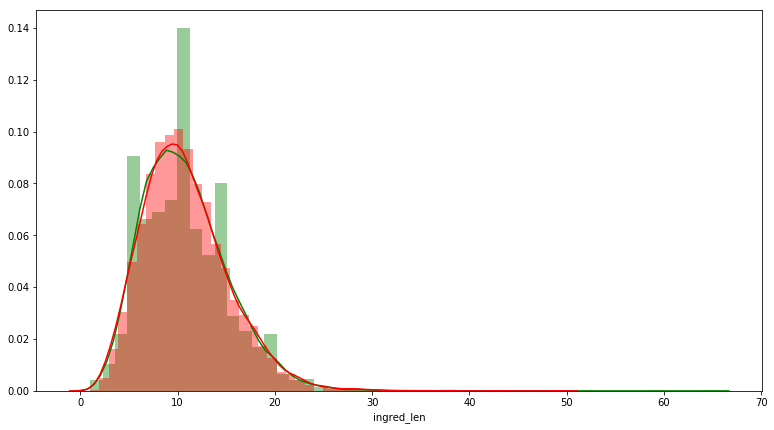

In [13]:
_, ax = plt.subplots(figsize=(13, 7))
sns.distplot(train_meta['ingred_len'], ax=ax, color='green')
sns.distplot(test_meta['ingred_len'], ax=ax, color='red')

In [14]:
train_meta['ingred_len'].agg(['min', 'max', 'mean', 'std'])

min      1.000000
max     65.000000
mean    10.762033
std      4.423210
Name: ingred_len, dtype: float64

In [15]:
train_meta_by_cuisine = train_meta.groupby('cuisine').agg({'ingred_len': ['min', 'max', 'mean', 'std']})
train_meta_by_cuisine

ingred_len                         
                    min max       mean       std
cuisine                                         
brazilian             2  59   9.713068  5.809419
british               2  30   9.638333  4.091303
cajun_creole          2  31  12.561207  4.630772
chinese               2  32  11.997021  4.023156
filipino              2  23  10.003546  3.613669
french                1  26   9.808371  4.126725
greek                 1  27  10.169265  3.719884
indian                1  40  12.728228  4.977895
irish                 2  25   9.287149  3.657340
italian               1  65   9.908551  3.820193
jamaican              2  35  12.133663  4.748457
japanese              1  34   9.836431  4.247813
korean                2  29  11.350649  3.797359
mexican               1  52  10.814368  4.677362
moroccan              2  31  12.919008  4.742898
russian               2  25  10.319444  4.090298
southern_us           1  40   9.610061  3.829878
spanish               1  35  10.392713  4.227759
thai                  1  40  12.589347  4.386694
vietnamese            1  31  12.690323  5.281501

In [17]:
train_meta_by_cuisine.std()

ingred_len  min      0.512989
            max     11.339266
            mean     1.290979
            std      0.583633
dtype: float64

  Might be useful as a feature

# Generating vectors

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
%%time
all_recipes = train + test
print(len(all_recipes))

39774
CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 9.65 ms


In [22]:
vectorizer = TfidfVectorizer()
all_ingredients = [' '.join(r['ingredients']) for r in all_recipes]
all_vectors = vectorizer.fit_transform(all_ingredients)
print(type(all_vectors))
assert(len(all_recipes) == all_vectors.shape[0])
print(all_vectors[0].shape)

<class 'scipy.sparse.csr.csr_matrix'>
(1, 3010)


# Generating features

In [23]:
meta_feature_columns = ['ingred_len']
meta.head()

,cuisine,ingred_len,train
29565,chinese,17,1
15528,italian,8,1
38015,cajun_creole,15,1
20511,italian,19,1
44111,chinese,14,1


In [24]:
features = meta[meta_feature_columns].values
features.shape

(39774, 1)

# Assembling model input

In [25]:
import scipy as sp
from sklearn.preprocessing import LabelEncoder

In [26]:
assert(all_vectors.shape[0] == features.shape[0])
data = sp.sparse.hstack([all_vectors, sp.sparse.csr_matrix(features)], format='csr')
type(data)

scipy.sparse.csr.csr_matrix

In [27]:
cousine_names = [r['cuisine'] for r in train]
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(cousine_names)

In [28]:
train_data = data[:len(labels)]
test_data = data[len(labels):]

# Model training and cross-validation

In [30]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

In [32]:
%%time
splitter = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
results = []
for fold, (train_idx_, eval_idx_) in enumerate(splitter.split(train_data, labels)):
    train_X_, train_y_ = train_data[train_idx_], labels[train_idx_]
    eval_X_, eval_y_ = train_data[eval_idx_], labels[eval_idx_]
    model_params = {
        'objective': 'multiclass',
        'n_estimators': 512,
        'n_classes': len(np.unique(labels)),
        'n_jobs': 12,
        'random_state': 42,
        'silent': True,
    }
    fit_params = {
        'eval_set': (eval_X_, eval_y_),
        'eval_metric': 'multi_error',
        'early_stopping_rounds': 64,
        'verbose': 16,
    }
    model = LGBMClassifier(**model_params)
    model.fit(train_X_, train_y_, **fit_params)
    score = model.score(eval_X_, eval_y_)
    print(f"Fold {fold}, val_accuracy={score}")
    results.append({
        'score': score,
        'model': model
    })

Training until validation scores don't improve for 64 rounds.
[16]	valid_0's multi_error: 0.300379	valid_0's multi_logloss: 1.27108
[32]	valid_0's multi_error: 0.269423	valid_0's multi_logloss: 1.00792
[48]	valid_0's multi_error: 0.249051	valid_0's multi_logloss: 0.88879
[64]	valid_0's multi_error: 0.237468	valid_0's multi_logloss: 0.825971
[80]	valid_0's multi_error: 0.232475	valid_0's multi_logloss: 0.792391
[96]	valid_0's multi_error: 0.226882	valid_0's multi_logloss: 0.772119
[112]	valid_0's multi_error: 0.223287	valid_0's multi_logloss: 0.759748
[128]	valid_0's multi_error: 0.220292	valid_0's multi_logloss: 0.752891
[144]	valid_0's multi_error: 0.218494	valid_0's multi_logloss: 0.748397
[160]	valid_0's multi_error: 0.215099	valid_0's multi_logloss: 0.746487
[176]	valid_0's multi_error: 0.212902	valid_0's multi_logloss: 0.747016
[192]	valid_0's multi_error: 0.211704	valid_0's multi_logloss: 0.747684
[208]	valid_0's multi_error: 0.211104	valid_0's multi_logloss: 0.750993
[224]	valid

# Submission generation
For a start, we will just perform simple voting from out-of-fold predictions

In [34]:
sample_subm = pd.read_csv('./input/sample_submission.csv')
print(sample_subm.shape)
sample_subm.head()

(9774, 2)


,Id,cuisine
0,24888,italian
1,43564,italian
2,21898,italian
3,6991,italian
4,37700,italian


In [35]:
result_ids = [r['id'] for r in test]
print(f"Using label encored: {label_encoder}")
print(f"Using result ids: {result_ids[:7]}...")

def generate_predictions(model_data) -> pd.DataFrame:
    model = model_data['model']
    preds = model.predict(test_data, num_iteration=model.best_iteration_)
    pred_names = label_encoder.inverse_transform(preds)
    return pd.DataFrame({
        'id': result_ids,
        'cuisine': pred_names
    })

Using label encored: LabelEncoder()
Using result ids: [24888, 43564, 21898, 6991, 37700, 43546, 20544]...


In [36]:
%%time
subm_dfs = [generate_predictions(model_data) for model_data in results]

CPU times: user 22.3 s, sys: 444 ms, total: 22.8 s
Wall time: 2.19 s


In [37]:
subm = pd.concat(subm_dfs)
print(subm.shape)
subm.head()

(58644, 2)


,id,cuisine
0,24888,italian
1,43564,spanish
2,21898,italian
3,6991,moroccan
4,37700,spanish


In [38]:
sp.stats.mode([1,2,2,3]).mode[0]

2

In [39]:
%%time
_sf = subm.groupby('id').cuisine.apply(lambda arr: sp.stats.mode(arr).mode[0])
subm_final = pd.DataFrame({
    'Id': _sf.index,
    'cuisine': _sf.values
})

/home/kk385830/miniconda3/envs/kaggle-cooking/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


CPU times: user 3.12 s, sys: 192 ms, total: 3.31 s
Wall time: 3.14 s


In [40]:
subm_final.head()

,Id,cuisine
0,16,indian
1,22,mexican
2,24,southern_us
3,32,japanese
4,48,indian


In [44]:
# sanity checks
assert(subm_final.notna().all().all())
assert(sorted(sample_subm['Id'].unique()) == sorted(subm_final['Id'].unique()))
assert(sample_subm.shape == subm_final.shape)

In [48]:
scores = [model_data['score'] for model_data in results]
mean_cv_score = np.mean(scores)
std_cv_score = np.std(scores)
model_name = 'LGBM'
subm_filename = f'{model_name}-cvmean={mean_cv_score:.4f}-cvstd={std_cv_score:.4f}.csv'
subm_path = os.path.join('./submissions/', subm_filename)
subm_path

'./submissions/LGBM-cvmean=0.7815-cvstd=0.0079.csv'

In [52]:
subm_final.to_csv(subm_path, index=False)

In [53]:
!kaggle competitions submit -f {subm_path} -m "Baseline" ml1819-whats-cooking

100%|████████████████████████████████████████| 136k/136k [00:02<00:00, 53.8kB/s]
Successfully submitted to ML1819 - What's Cooking?

# Possible improvements

- For a baseline, we have only vectorized words, so multi-word ingredients are treated the same as single-word ones - 
  it may be beneficial to separate the ingredient and its modifiers
- TfIdf does not take position on the list into account - need to try other vectorization techniques
- Testing other models: NNs in particular might work well on such dataset - if well-made we can use them 
  to take order and comma-separation of ingredients vs their modifiers into account